# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

# Reading file and tidying

In [71]:
df = pd.read_csv("loanprediction.csv")
df.drop("Id", axis=1, inplace=True)
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
#numerical_cols = ["income", "age", "experience", "current_job_years", "current_house_years"]
#df.info()

# Feature selection
H0 :- There is no relationship between categorical feature and target variable\
H1 :- There is some relationship between categorical feature and target variable\
If p-value ≥0.05, the null hypothesis is not rejected and there is no any relationship between target variable and categorical features.

## Chi-Square

In [72]:
# # https://medium.com/analytics-vidhya/categorical-feature-selection-using-chi-squared-test-e4c0d0af6b7e
# # https://towardsdatascience.com/using-the-chi-squared-test-for-feature-selection-with-implementation-b15a4dad93f1

# # Standardisation gives negative values, chi-square does not allow negative values

# chi_scores = chi2(x,y)
# p_values = pd.Series(chi_scores[1],index = x.columns)
# p_values.sort_values(ascending = False , inplace = True)
# p_values.plot.bar()

# # conclusion: current_house_years, profession_encoded, state_encoded have no relationship with target variable
# x = x.drop(["current_house_years", "profession_encoded", "state_encoded"], axis=1)

## PCA

In [73]:
# pca_loan = PCA()
# x_train = pca_loan.fit_transform(x_train)
# x_test = pca_loan.fit_transform(x_test)

# Train test split

In [74]:
y = df["risk_flag"]
x = df.drop("risk_flag", axis=1)

In [75]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

In [76]:
x_train = x_train.drop(["current_house_years", "profession", "state"], axis=1)
x_test = x_test.drop(["current_house_years", "profession", "state"], axis=1)

# Data preprocessing - Encoding categorical columns and scaling numerical columns

In [77]:
def data_preprocessing(df_x, df_y):
    # Label encoding categorical columns with 2 types of categories
    x = df_x.copy()
    label_enc = LabelEncoder()
    x["marital_status"] = label_enc.fit_transform(x["marital_status"])
    x["car_ownership"] = label_enc.fit_transform(x["car_ownership"])
    
    # One Hot Encoding house_ownership column & Combining back to dataframe
    onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    
    house_ownership_values = onehot_encoder.fit_transform( x[['house_ownership']] )
    house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
    house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

    x.reset_index(drop=True, inplace=True)
    house_ownership_df.reset_index(drop=True, inplace=True)
    x = pd.concat([ x, house_ownership_df], axis=1)
    
    x.drop("house_ownership", axis=1, inplace=True)
    
    # Target Encoding the high cardinality categorical columns: profession, city, state
    # https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64
#     profession_target_enc = TargetEncoder()
#     x["profession_encoded"] = profession_target_enc.fit_transform(x["profession"], df_y)
    city_target_enc = TargetEncoder()
    x["city_encoded"] = city_target_enc.fit_transform(x["city"], df_y)
#     state_target_enc = TargetEncoder()
#     x["state_encoded"] = state_target_enc.fit_transform(x["state"], df_y)
#     x.drop("profession", axis=1, inplace=True)
    x.drop("city", axis=1, inplace=True)
#    x.drop("state", axis=1, inplace=True)
    
    # https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
    # https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/
#     min_max_scaler = MinMaxScaler()
#     x[numerical_cols] = min_max_scaler.fit_transform(x[numerical_cols])
    
    return x

In [78]:
x_train = data_preprocessing(x_train, y_train)

In [79]:
# pca_loan = PCA()
# x_train = pca_loan.fit_transform(x_train)

#### Perform oversampling on train data

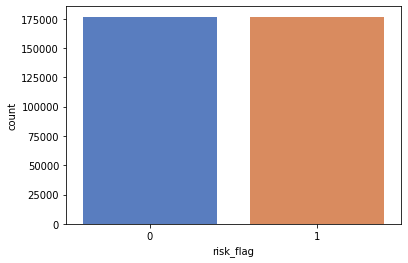

In [80]:
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

sns.countplot(x = y_train, palette = 'muted')

#### Applying xgboost model

In [81]:
dtree = tree.DecisionTreeClassifier(min_samples_leaf=12 ,random_state=69)

dtree.fit(x_train, y_train)
x_test = data_preprocessing(x_test, y_test)
#x_test = pca_loan.fit_transform(x_test)
y_pred = dtree.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[32143 12154]
 [ 3346  2757]]


In [82]:
print("-------------------------TEST SCORES-----------------------  ")
print(f"Recall: {recall_score(y_test, y_pred)}  ")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)}  ")
print("Fbeta:",((5*precision_score(y_test, y_pred)*recall_score(y_test, y_pred))/
                 (4*precision_score(y_test, y_pred)+recall_score(y_test, y_pred)))," ")
print(f"Precision: {precision_score(y_test, y_pred)}  ")
print(f"F1-Score: {f1_score(y_test, y_pred)}  ")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}  ")

-------------------------TEST SCORES-----------------------  
Recall: 0.45174504342126826  
AUC Score: 0.5886849017815192  
Fbeta: 0.3505581974925616  
Precision: 0.1848970558647978  
F1-Score: 0.26239649757304656  
Accuracy score: 0.6924603174603174  


Real shit, 6 tests

control, no pca, no chisq, no smote  
-------------------------TEST SCORES-----------------------  
Recall: 0.2523349172538096  
AUC Score: 0.5191624695757275  
Fbeta: 0.21731767893429665  
Precision: 0.1397459165154265  
F1-Score: 0.17987502190036794  
Accuracy score: 0.7213690476190476  

PCA and no SMote  
-------------------------TEST SCORES-----------------------  
Recall: 0.25102408651482877  
AUC Score: 0.529997674338526  
Fbeta: 0.22263558681625298  
Precision: 0.15329197518511106  
F1-Score: 0.19034602721003913  
Accuracy score: 0.7414087301587302  

PCA with smote  
-------------------------TEST SCORES-----------------------  
Recall: 0.24987710961822054  
AUC Score: 0.4987900571681866  
Fbeta: 0.20545361463638082  
Precision: 0.12006928588300134  
F1-Score: 0.162199532014465  
Accuracy score: 0.6874206349206349  

CHIsq no smote  
-------------------------TEST SCORES-----------------------  
Recall: 0.2742913321317385  
AUC Score: 0.5577836325195794  
Fbeta: 0.25274028444605495  
Precision: 0.192303273980471  
F1-Score: 0.22609400324149112  
Accuracy score: 0.7726190476190476  

Chi sq with smote  
-------------------------TEST SCORES-----------------------  
Recall: 0.45174504342126826  
AUC Score: 0.5886849017815192  
Fbeta: 0.3505581974925616  
Precision: 0.1848970558647978  
F1-Score: 0.26239649757304656  
Accuracy score: 0.6924603174603174  

both no smote
-------------------------TEST SCORES-----------------------  
Recall: 0.3201704079960675  
AUC Score: 0.5094542357609071  
Fbeta: 0.2460275490418272  
Precision: 0.1277207660631414  
F1-Score: 0.1825997570320531  
Accuracy score: 0.6528968253968254  

Both with smote 
-------------------------TEST SCORES-----------------------  
Recall: 0.3650663608061609  
AUC Score: 0.5030402124820023  
Fbeta: 0.2618588688825161  
Precision: 0.12289023717595146  
F1-Score: 0.18388148392687656  
Accuracy score: 0.6075992063492064  



TRIAL

first round : 12 levels, jons datapreproc, scaling of numerics\
-------------------------TEST SCORES-----------------------\
Recall: 0.2890381779452728\
Precision: 0.1267332423306272\
F1-Score: 0.1762061732094696\
Accuracy score: 0.6727380952380952\
AUC Score: 0.5073201815974191\

12 levels, jons datapreproc, no more scaling\
-------------------------TEST SCORES-----------------------\
Recall: 0.2890381779452728\
Precision: 0.1267332423306272\
F1-Score: 0.1762061732094696\
Accuracy score: 0.6727380952380952\
AUC Score: 0.5073201815974191\

12 levels, jons datapreproc, no more scaling, no more "handle_unknown='ignore'\
-------------------------TEST SCORES-----------------------\
Recall: 0.35720137637227595\
Precision: 0.13993195968932537\
F1-Score: 0.201088460474126\
Accuracy score: 0.6563095238095238\
AUC Score: 0.5273601978594793\

12 levels, jons datapreproc, no more scaling,\
-------------------------TEST SCORES-----------------------\
Recall: 0.34065213829264296\
Precision: 0.14486795345272108\
F1-Score: 0.20328542094455854\
Accuracy score: 0.6766666666666666\
AUC Score: 0.5318065305771182\